In [1]:
import sys
sys.path.append('../..')
from keras.models import Sequential, Model
from keras import layers
from keras import Input

from data_tools import *
from data_tools import IOTools as it
from data_tools import PandasTools as pt
from data_tools import ChartTools as ct

ct.IPYTHON_MODE = True

Using TensorFlow backend.


### Keras 建模两种方式

#### Sequential 实现模型

In [24]:
# 建模
seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,)))
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))
print(seq_model.summary())

# 模型优化
seq_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# 模型训练
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10))
seq_model.fit(x_train, y_train, epochs=3, batch_size=128)

# 模型评估
score = seq_model.evaluate(x_train, y_train)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
1000/1000 [==============================] - 0s 156us/step - loss: 11.6550
Epoch 2/3
1000/1000 [==============================] - 0s 11us/step - loss: 11.5060
Epoch 3/3
1000/1000 [==============================] - 0s 93us/step


#### API 实现模型

In [22]:
# 建模
input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model = Model(input_tensor, output_tensor)
print(model.summary())

# 模型优化
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# 模型训练
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10))
model.fit(x_train, y_train, epochs=3, batch_size=128)

# 模型评估
score = model.evaluate(x_train, y_train)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
1000/1000 [==============================] - 0s 134us/step - loss: 11.7290
Epoch 2/3
1000/1000 [==============================] - 0s 9us/step - loss: 11.6044
Epoch 3/3
1000/1000 [==============================] - 0s 71us/step


### keras 多输入模型（问答模型）
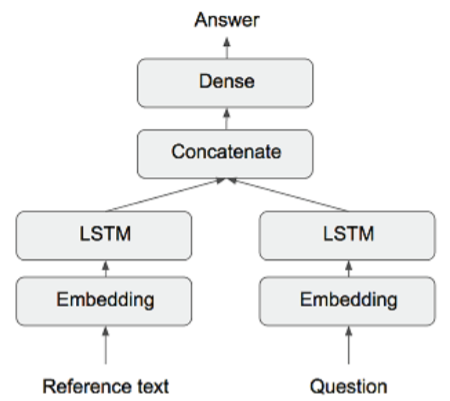

#### 建模

In [31]:
# 常量
text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# 左分支（参考文输入）
text_input = Input(shape=(None,), dtype='int32', name='text')
embedded_text = layers.Embedding(64, text_vocabulary_size)(text_input)
encoded_text = layers.LSTM(32)(embedded_text)

# 右分支（问题输入）
question_input = Input(shape=(None,), dtype='int32', name='question')
embedded_question = layers.Embedding(32, question_vocabulary_size)(question_input)
encoded_question = layers.LSTM(16)(embedded_question)

# 合并输入
concatenated = layers.concatenate([encoded_text, encoded_question], axis=-1)

answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)

model = Model([text_input, question_input], answer)
model.compile(optimizer='rmsprop',
 loss='categorical_crossentropy',
 metrics=['acc'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 10000)  640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 10000)  320000      question[0][0]                   
____________________________________________________________________________________________

#### 训练

In [ ]:
num_samples=100
max_length=1000
text = np.random.randint(1, text_vocabulary_size, size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size, size=(num_samples, max_length))
answers = np.random.randint(0, 1, size=(num_samples, ))

model.fit([text, question], answers, epochs=3, batch_size=50)
# model.fit({'text': text, 'question': question}, answers,
#  epochs=10, batch_size=128)

### keras 多输出模型
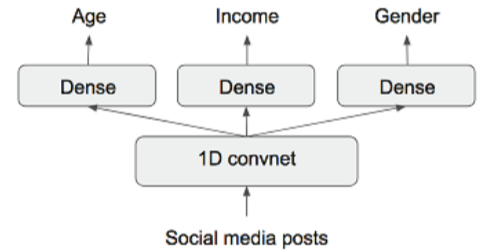

#### 建模

In [22]:

vocabulary_size = 200
num_income_groups = 10
posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(256, vocabulary_size)(posts_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)

age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups, activation='softmax', name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)

model = Model(posts_input, [age_prediction, income_prediction, gender_prediction])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    51200       posts[0][0]                      
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 128)    128128      embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, None, 128)    0           conv1d_2[0][0]                   
____________________________________________________________________________________________

#### 训练

In [ ]:
## 无权重损失
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])

# model.compile(optimizer='rmsprop',
#  loss={'age': 'mse',
#  'income': 'categorical_crossentropy',
#  'gender': 'binary_crossentropy'})

## 带权重损失
# model.compile(optimizer='rmsprop',
#  loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
#  loss_weights=[0.25, 1., 10.])

# model.compile(optimizer='rmsprop',
#  loss={'age': 'mse',
#  'income': 'categorical_crossentropy',
#  'gender': 'binary_crossentropy'},
#  loss_weights={'age': 0.25,
#  'income': 1.,
#  'gender': 10.})
posts = np.random.randint(1, size=(100, 500))
age_targets = np.random.randint(0, 1, size=100)
income_targets = np.random.randint(1, 1000, size=(100, num_income_groups))
gender_targets = np.random.randint(0, 1, size=100)

model.fit(posts, [age_targets, income_targets, gender_targets],
          epochs=2,
          batch_size=64)
# model.fit(posts, {'age': age_targets,
#  'income': income_targets,
#  'gender': gender_targets},ii
#  epochs=10, batch_size=64)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10


### keras 多链路模型
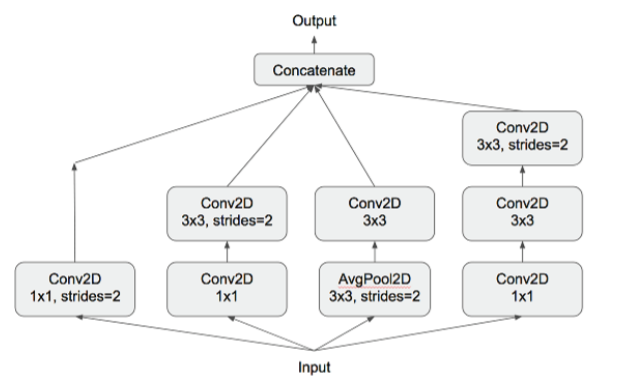

In [ ]:
x = Input(shape=(128,128,3), dtype='float32')

branch_a = layers.Conv2D(128, 1, activation='relu', strides=2)(x)

branch_b = layers.Conv2D(128, 1, activation='relu')(x)
branch_b = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_b)

branch_c = layers.AveragePooling2D(3, strides=2)(x)
branch_c = layers.Conv2D(128, 3, activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, activation='relu')(x)
branch_d = layers.Conv2D(128, 3, activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_d)

output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)

model = Model(x,output)
model.summary()

### keras 残差网络结构
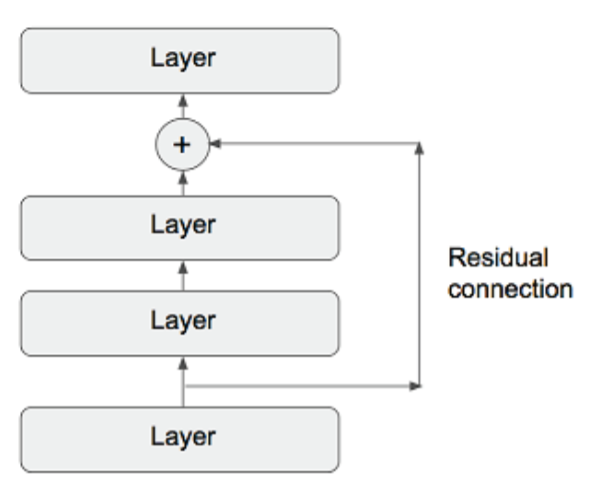

In [ ]:
x = ...
y = layers.Conv2D(128, 3, activation='relu')(x)
y = layers.Conv2D(128, 3, activation='relu')(y)
y = layers.Conv2D(128, 3, activation='relu')(y)
y = layers.add([y, x])

In [ ]:
x = ...
y = layers.Conv2D(128, 3, activation='relu')(x)
y = layers.Conv2D(128, 3, activation='relu')(y)
y = layers.MaxPooling2D(2, strides=2)(y)
residual = layers.Conv2D(1, strides=2)(x)
# We add the residual tensor back to the output features
y = layers.add([y, residual])

### keras 权重分享

In [ ]:
# 这里lstm层被复用，权重共享一份
lstm = layers.LSTM(32)

left_input = Input(shape=(None, 128))
left_output = lstm(left_input)

right_input = Input(shape=(None, 128))
right_output = lstm(right_input)

merged = layers.concatenate([left_output, right_output], axis=-1)
predictions = layers.Dense(1, activation='sigmoid')(merged)

model = Model([left_input, right_input], predictions)
model.fit([left_data, right_data], targets)

In [ ]:
from keras import applications

xception_base = applications.Xception(weights=None, include_top=False)

left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

# 这里通用网络结构xception作为模型被复用，其权重共享一份
left_features = xception_base(left_input)
right_input = xception_base(right_input)

merged_features = layers.concatenate([left_features, right_input], axis=-1)

### keras 模型回调操作
1. Model checkpointing：在训练时的不同节点保存当前的模型权重
2. Early stopping：在验证集合损失值不再提升时，中断当前训练，存储最佳模型
3. Dynamically adjusting：在训练过程中，动态调整核心参数，例如学习率
4. Logging：记录训练过程中，训练集、验证集的评估指标
以下常用回调操作：
> * keras.callbacks.ModelCheckpoint
> * keras.callbacks.EarlyStopping
> * keras.callbacks.LearningRateScheduler
> * keras.callbacks.ReduceLROnPlateau
> * keras.callbacks.CSVLogger

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        # 监控指标
        monitor='acc',
        # Training will be interrupted when the accuracy
        # has stopped improving for *more* than 1 epochs (i.e. 2 epochs)
        # 开始生效批次
        patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        # 模型存储位置
        filepath='my_model.h5',
        # 监控指标
        monitor='val_loss',
        # 是否只保存最佳模型，自始至终，会覆盖上次最佳
        save_best_only=True,
    )
]

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.fit(x, y,
 epochs=10,
 batch_size=32,
 callbacks=callbacks_list,
 validation_data=(x_val, y_val))

In [ ]:
callbacks_list = [
    # 当验证集的损失值停止提升时
    keras.callbacks.ReduceLROnPlateau(
        # 监控指标
        monitor='val_loss',
        # 学习率变为原先的0.1倍
        factor=0.1,
        # It will get triggered after the validation loss has stopped improving
        # for at least 10 epochs
        # 开始生效批次
        patience=10,
    )
]
# 需要传入验证集合
model.fit(x,
          y,
          epochs=10,
          batch_size=32,
          callbacks=callbacks_list,
          validation_data=(x_val, y_val))

#### 自定义回调器

In [ ]:
class ActivationLogger(keras.callbacks.Callback):
    def set_model(self, model):
        # This method is called by the parent model
        # before training, to inform the callback
        # of what model will be calling it
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        # This is a model instance that returns the activations of every layer
        self.activations_model = keras.models.Model(model.input, layer_outputs)

    def on_epoch_end(self, epoch, logs=None):
        """
        另外可使用的函数有
            on_epoch_begin
            on_epoch_end
            on_batch_begin
            on_batch_end
            on_train_begin
            on_train_end
        """
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
        # Obtain first input sample of the validation data
        validation_sample = self.validation_data[0][0:1]
        activations = self.activations_model.predict(validation_sample)
        # Save arrays to disk
        f = open('activations_at_epoch_' + str(epoch) + '.npz', 'w')
        np.savez(f, activations)
        f.close()